
# HTF + LTF FVG Rebound Backtester



In [38]:

import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import List, Optional, Dict
from datetime import time
import pytz
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 100)
pd.set_option("display.width", 200)


In [ ]:

# =====================
# User Parameters
# =====================
CSV_PATH = "MES.csv"  # set to your 1-minute futures CSV

DATA_TZ = "UTC"
SESSION_TZ = "America/New_York"
SESSION_START = "06:30"
SESSION_END   = "09:00"

HTF = "1H"   # examples: "1H", "15T"
LTF = "5T"   # examples: "5T", "1T"

FVG_LOOKBACK = 2
# Separate minimum sizes (price units) for HTF vs LTF FVGs (your n1 / n2 knobs)
HTF_MIN_GAP = 4
LTF_MIN_GAP = 2
CLOSE_GAP_ON_TOUCH = True

REQUIRE_FULL_CONTAINMENT = True
CONFIRM_WITH_BODY = True
LTF_SIGNAL_TTL_MIN = 120   # how long (minutes) an LTF signal stays tradeable after forming
ALLOW_PARTIAL_CONTAINMENT = False  # set True to test more relaxed confluence

USE_TREND_FILTER = True
TREND_EMA_PERIOD = 20

SL_MODE = "pivot"   # "pivot" or "gap"
PIVOT_LOOKBACK = 5
GAP_SL_BUFFER = 0.0

R_MULT_TP = 2
R_MULT_TRAIL = None

# Logging
LOG_FVGS = True           # print FVG tables & counts
PRINT_TOP_FVGS = 20       # how many samples to show when logging
LOG_TRIGGERS = True     # log when an active signal is evaluated / entered / invalidated

# -------- Gap penetration rules (fraction of gap size, 0..1) --------
# Example: HTF needs only 25% fill; LTF needs ~full (e.g., 90–100%)
HTF_MIN_FILL_PCT = 0.25
LTF_MIN_FILL_PCT = 0.95

# If True, also *prefer* entries that are closer to the "far" side
# (upper edge for bearish, lower edge for bullish) by requiring
# current fraction to be >= (threshold) as defined above.
PREFER_EXTREME_INSIDE_HTF = True

# Review plot export
SAVE_DIR = "review_charts"   # folder (created if missing)
N_REVIEW  = 10               # how many trade charts to auto-save
PLOT_PAD_MIN = 60            # minutes before/after trade window to show

START_DATE = None  # e.g., "2024-09-01"
END_DATE   = None

# Entry style:
#  - "limit": enter the moment price reaches the required penetration level (treat as limit fill)
#  - "close": enter at the close of the confirming bar (current behavior)
ENTRY_MODE = "limit"

# If ENTRY_MODE == "limit", also require a momentum confirmation on the same bar?
#  - True: still require body-direction (safer, fewer trades)
#  - False: pure limit touch (more entries)
CONFIRM_ON_LIMIT = False

# Optional slippage in price units applied to limit fills (0 = none)
LIMIT_SLIPPAGE = 0.0

In [40]:

def load_1m_csv(path: str, data_tz="UTC"):
    df = pd.read_csv(path)
    req = {"time","open","high","low","close","Volume"}
    missing = req - set(df.columns)
    if missing:
        raise ValueError(f"CSV missing columns: {missing}")
    df["timestamp"] = pd.to_datetime(df["time"], unit="s", utc=True)
    if data_tz and data_tz.upper() != "UTC":
        df["timestamp"] = df["timestamp"].dt.tz_convert(data_tz).dt.tz_convert("UTC")
    df = df.sort_values("timestamp").set_index("timestamp")
    for c in ["open","high","low","close","Volume"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

raw_1m = load_1m_csv(CSV_PATH, DATA_TZ)
if START_DATE:
    raw_1m = raw_1m[raw_1m.index >= pd.Timestamp(START_DATE, tz="UTC")]
if END_DATE:
    raw_1m = raw_1m[raw_1m.index <= pd.Timestamp(END_DATE, tz="UTC")]

print(raw_1m.head())
print("Rows:", len(raw_1m), "Range:", raw_1m.index.min(), "→", raw_1m.index.max())


                                 time     open     high      low    close         VWAP  Upper Band #1  Lower Band #1  Volume
timestamp                                                                                                                   
2025-10-19 22:00:00+00:00  1760911200  6720.75  6726.50  6719.00  6720.00  6721.833333    6721.833333    6721.833333    1883
2025-10-19 22:01:00+00:00  1760911260  6720.75  6721.25  6718.25  6718.25  6721.115906    6722.272907    6719.958905     724
2025-10-19 22:02:00+00:00  1760911320  6718.00  6720.75  6716.75  6717.75  6720.603403    6722.088392    6719.118414     611
2025-10-19 22:03:00+00:00  1760911380  6717.75  6718.75  6715.25  6716.25  6719.973356    6721.941985    6718.004727     629
2025-10-19 22:04:00+00:00  1760911440  6716.25  6717.75  6715.50  6716.25  6719.513532    6721.692553    6717.334511     587
Rows: 12739 Range: 2025-10-19 22:00:00+00:00 → 2025-10-31 03:21:00+00:00


In [41]:

def to_session_mask(idx_utc: pd.DatetimeIndex, session_tz: str, start_hhmm: str, end_hhmm: str):
    tz = pytz.timezone(session_tz)
    local = idx_utc.tz_convert(tz)
    start_h, start_m = map(int, start_hhmm.split(":"))
    end_h, end_m = map(int, end_hhmm.split(":"))
    start_t, end_t = time(start_h, start_m), time(end_h, end_m)
    return pd.Series([(t >= start_t) and (t < end_t) for t in local.time], index=idx_utc)

def resample_ohlc(df: pd.DataFrame, rule: str):
    o = df["open"].resample(rule).first()
    h = df["high"].resample(rule).max()
    l = df["low"].resample(rule).min()
    c = df["close"].resample(rule).last()
    v = df["Volume"].resample(rule).sum()
    return pd.DataFrame({"open":o,"high":h,"low":l,"close":c,"Volume":v}).dropna()

def ema(s: pd.Series, n: int):
    return s.ewm(span=n, adjust=False).mean()

def is_pivot_high(highs: pd.Series, i: int, k: int):
    left = highs.iloc[max(0,i-k):i]
    right= highs.iloc[i+1:i+1+k]
    return (len(left)==k) and (len(right)==k) and (highs.iloc[i] > left.max()) and (highs.iloc[i] > right.max())

def is_pivot_low(lows: pd.Series, i: int, k: int):
    left = lows.iloc[max(0,i-k):i]
    right= lows.iloc[i+1:i+1+k]
    return (len(left)==k) and (len(right)==k) and (lows.iloc[i] < left.min()) and (lows.iloc[i] < right.min())


In [42]:

from dataclasses import dataclass

@dataclass
class FVG:
    start_time: pd.Timestamp
    end_time: pd.Timestamp
    lower: float
    upper: float
    direction: str  # "bullish" or "bearish"
    active: bool = True

def detect_fvgs(df: pd.DataFrame, lookback=2, min_gap=0.0):
    highs, lows = df["high"], df["low"]
    idx = df.index
    out = []
    for i in range(lookback, len(df)):
        # Bullish gap (inefficiency up)
        if lows.iloc[i] > highs.iloc[i-lookback]:
            lower = highs.iloc[i-lookback]
            upper = lows.iloc[i]
            if (upper - lower) >= min_gap:
                out.append(FVG(idx[i-lookback], idx[i], lower, upper, "bullish"))
        # Bearish gap (inefficiency down)
        if highs.iloc[i] < lows.iloc[i-lookback]:
            lower = highs.iloc[i]
            upper = lows.iloc[i-lookback]
            if (upper - lower) >= min_gap:
                out.append(FVG(idx[i-lookback], idx[i], lower, upper, "bearish"))
    return out

def fvgs_to_frame(fvgs):
    if not fvgs:
        return pd.DataFrame(columns=["start_time","end_time","lower","upper","direction","active","size"])
    rows = []
    for f in fvgs:
        rows.append({
            "start_time": f.start_time, "end_time": f.end_time,
            "lower": f.lower, "upper": f.upper, "direction": f.direction,
            "active": f.active, "size": f.upper - f.lower
        })
    df = pd.DataFrame(rows).sort_values(["end_time","start_time"]).reset_index(drop=True)
    return df

def update_fvg_active_status(fvg: FVG, price: float, close_on_touch=True):
    if not fvg.active:
        return
    if fvg.direction == "bullish" and price < fvg.lower and close_on_touch:
        fvg.active = False
    elif fvg.direction == "bearish" and price > fvg.upper and close_on_touch:
        fvg.active = False

def gap_fraction(price: float, gap: FVG) -> float:
    """
    Returns penetration fraction (0..1) toward the 'far side' used for entries:
      - Bearish gap: want entries near UPPER bound => (price - lower)/size
      - Bullish gap: want entries near LOWER bound => (upper - price)/size
    Clipped to [0,1].
    """
    size = max(gap.upper - gap.lower, 1e-12)
    if gap.direction == "bearish":
        frac = (price - gap.lower) / size
    else:  # bullish
        frac = (gap.upper - price) / size
    return float(min(1.0, max(0.0, frac)))

In [43]:

# Build timeframes & FVGs
one_min = raw_1m.copy()
htf = resample_ohlc(one_min, HTF)
ltf = resample_ohlc(one_min, LTF)
htf["ema"] = ema(htf["close"], TREND_EMA_PERIOD) if USE_TREND_FILTER else np.nan

htf_fvgs = detect_fvgs(htf, lookback=FVG_LOOKBACK, min_gap=HTF_MIN_GAP)
ltf_fvgs = detect_fvgs(ltf, lookback=FVG_LOOKBACK, min_gap=LTF_MIN_GAP)

print(f"HTF FVGs: {len(htf_fvgs)} | LTF FVGs: {len(ltf_fvgs)}")

if LOG_FVGS:
    htf_df = fvgs_to_frame(htf_fvgs)
    ltf_df = fvgs_to_frame(ltf_fvgs)
    def _preview(df, name):
        if df.empty:
            print(f"[LOG] {name}: none")
        else:
            print(f"[LOG] {name} (top by size):")
            display(df.sort_values("size", ascending=False).head(PRINT_TOP_FVGS))
    _preview(htf_df, "HTF FVGs")
    _preview(ltf_df, "LTF FVGs")


HTF FVGs: 16 | LTF FVGs: 110
[LOG] HTF FVGs (top by size):


,start_time,end_time,lower,upper,direction,active,size
8,2025-10-24 20:00:00+00:00,2025-10-26 23:00:00+00:00,6829.50,6869.25,bullish,True,39.75
7,2025-10-24 19:00:00+00:00,2025-10-26 22:00:00+00:00,6841.00,6865.75,bullish,True,24.75
2,2025-10-20 12:00:00+00:00,2025-10-20 14:00:00+00:00,6734.25,6747.25,bullish,True,13.00
15,2025-10-30 19:00:00+00:00,2025-10-30 22:00:00+00:00,6878.25,6890.75,bullish,True,12.50
6,2025-10-24 11:00:00+00:00,2025-10-24 13:00:00+00:00,6800.00,6812.25,bullish,True,12.25
9,2025-10-27 18:00:00+00:00,2025-10-27 20:00:00+00:00,6898.75,6907.00,bullish,True,8.25
5,2025-10-23 00:00:00+00:00,2025-10-23 02:00:00+00:00,6738.00,6745.75,bullish,True,7.75
3,2025-10-20 13:00:00+00:00,2025-10-20 15:00:00+00:00,6754.75,6762.25,bullish,True,7.50
4,2025-10-22 18:00:00+00:00,2025-10-22 20:00:00+00:00,6724.00,6731.50,bullish,True,7.50
1,2025-10-20 11:00:00+00:00,2025-10-20 13:00:00+00:00,6724.75,6731.75,bullish,True,7.00


[LOG] LTF FVGs (top by size):


,start_time,end_time,lower,upper,direction,active,size
57,2025-10-24 20:55:00+00:00,2025-10-26 22:05:00+00:00,6826.25,6872.25,bullish,True,46.00
56,2025-10-24 20:50:00+00:00,2025-10-26 22:00:00+00:00,6826.50,6865.75,bullish,True,39.25
71,2025-10-29 18:30:00+00:00,2025-10-29 18:40:00+00:00,6905.25,6932.75,bearish,True,27.50
50,2025-10-24 12:25:00+00:00,2025-10-24 12:35:00+00:00,6798.00,6815.00,bullish,True,17.00
94,2025-10-30 13:40:00+00:00,2025-10-30 13:50:00+00:00,6881.75,6893.25,bullish,True,11.50
83,2025-10-30 04:00:00+00:00,2025-10-30 04:10:00+00:00,6932.50,6943.00,bearish,True,10.50
105,2025-10-30 19:55:00+00:00,2025-10-30 20:05:00+00:00,6858.50,6868.75,bullish,True,10.25
84,2025-10-30 04:05:00+00:00,2025-10-30 04:15:00+00:00,6921.50,6931.50,bearish,True,10.00
36,2025-10-22 18:15:00+00:00,2025-10-22 18:25:00+00:00,6703.50,6712.00,bullish,True,8.50
9,2025-10-20 13:25:00+00:00,2025-10-20 13:35:00+00:00,6736.00,6744.25,bullish,True,8.25


In [44]:

def fvg_contains(inner: FVG, outer: FVG) -> bool:
    return (inner.lower >= outer.lower) and (inner.upper <= outer.upper)

def ltf_fvg_within_active_htf(ltf_fvg: FVG, htf_fvgs: List[FVG]) -> Optional[FVG]:
    candidates = [f for f in htf_fvgs if f.active and f.start_time <= ltf_fvg.start_time]
    if not candidates:
        return None
    outer = candidates[-1]
    if REQUIRE_FULL_CONTAINMENT and not fvg_contains(ltf_fvg, outer):
        return None
    if ALLOW_PARTIAL_CONTAINMENT and not REQUIRE_FULL_CONTAINMENT:
        # allow partial overlap (still require some intersection)
        if not ((ltf_fvg.upper >= outer.lower) and (ltf_fvg.lower <= outer.upper)):
            return None
    if outer.direction != ltf_fvg.direction:
        return None
    return outer

def candle_touches_gap(o,h,l,c,gap: FVG):
    return (h >= gap.lower and l <= gap.upper)

def confirm_rebound(o,h,l,c,direction: str, with_body=True):
    if not with_body:
        return True
    return (c < o) if direction=="bearish" else (c > o)


In [45]:
import os

def _ensure_dir(path):
    if path and not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

def plot_trade_review(trades_df: pd.DataFrame,
                      df_1m: pd.DataFrame,
                      trade_idx: int,
                      save_dir: str = SAVE_DIR,
                      pad_minutes: int = PLOT_PAD_MIN):
    """
    Plot a single trade with HTF/LTF FVG boxes, entry/stop/TP/exit markers.
    Saves to PNG and returns the save path.
    """
    if trade_idx < 0 or trade_idx >= len(trades_df):
        raise IndexError("trade_idx out of range.")

    r = trades_df.iloc[trade_idx]
    t0 = r["entry_time"] - pd.Timedelta(minutes=pad_minutes)
    t1 = (r["exit_time"] if pd.notnull(r["exit_time"]) else r["entry_time"]) + pd.Timedelta(minutes=pad_minutes)
    seg = df_1m[(df_1m.index >= t0) & (df_1m.index <= t1)]
    if seg.empty:
        raise ValueError("No data in chosen window; adjust pad_minutes.")

    fig = plt.figure(figsize=(12,6))
    ax = plt.gca()

    # price line (close only for clarity)
    ax.plot(seg.index, seg["close"].values, linewidth=1.0)

    # FVG rectangles (if present)
    def draw_box(y0,y1,color,alpha=0.15,label=None):
        ax.axhspan(y0, y1, alpha=alpha, label=label, edgecolor=None, facecolor=color)

    # HTF (wider, lighter)
    if pd.notnull(r.get("htf_lower")) and pd.notnull(r.get("htf_upper")):
        draw_box(r["htf_lower"], r["htf_upper"], color="gray", alpha=0.12, label="HTF FVG")

    # LTF (darker overlay)
    if pd.notnull(r.get("ltf_lower")) and pd.notnull(r.get("ltf_upper")):
        draw_box(r["ltf_lower"], r["ltf_upper"], color="orange", alpha=0.20, label="LTF FVG")

    # Entry / Stop / TP / Exit
    ax.axhline(r["entry_price"], linestyle="--", linewidth=1.0)
    ax.text(seg.index[0], r["entry_price"], " entry", va="bottom", fontsize=8)

    ax.axhline(r["stop_price"], linestyle=":", linewidth=1.0)
    ax.text(seg.index[0], r["stop_price"], " stop", va="bottom", fontsize=8)

    ax.axhline(r["tp_price"], linestyle=":", linewidth=1.0)
    ax.text(seg.index[0], r["tp_price"], " tp", va="bottom", fontsize=8)

    ax.scatter([r["entry_time"]], [r["entry_price"]], marker="^" if r["direction"]=="bullish" else "v", s=60)
    if pd.notnull(r["exit_time"]):
        ax.scatter([r["exit_time"]], [r["exit_price"]], marker="x", s=60)

    title = f"Trade #{trade_idx} | {r['direction']} | pnl={r['pnl']:.2f} | R={r['R']:.2f if pd.notnull(r['R']) else float('nan')}"
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Price")
    # legend dedup
    handles, labels = ax.get_legend_handles_labels()
    if labels:
        ax.legend(loc="best")

    _ensure_dir(save_dir)
    out_path = os.path.join(save_dir, f"trade_{trade_idx:04d}.png")
    plt.tight_layout()
    plt.savefig(out_path, dpi=140)
    plt.show()
    return out_path

def save_first_n_trade_charts(trades_df: pd.DataFrame, df_1m: pd.DataFrame, n: int = N_REVIEW):
    k = min(len(trades_df), n)
    paths = []
    for i in range(k):
        try:
            p = plot_trade_review(trades_df, df_1m, i)
            paths.append(p)
        except Exception as e:
            print(f"[WARN] Could not plot trade {i}: {e}")
    print(f"[INFO] Saved {len(paths)} chart(s) to '{SAVE_DIR}'")
    return paths

def index_at_or_before(idx: pd.DatetimeIndex, t: pd.Timestamp) -> pd.Timestamp:
    """
    Return the index label at or before t (like 'pad' / ffill).
    Raises KeyError if nothing exists at/before t.
    """
    pos = idx.get_indexer([t], method="pad")
    if len(pos) == 0 or pos[0] == -1:
        raise KeyError("no label at or before timestamp")
    return idx[pos[0]]

In [46]:

from dataclasses import dataclass

@dataclass
class Trade:
    entry_time: pd.Timestamp
    direction: str
    entry_price: float
    stop_price: float
    tp_price: float
    exit_time: Optional[pd.Timestamp] = None
    exit_price: Optional[float] = None
    pnl: Optional[float] = None
    reason: str = ""
    # extras for review/metrics
    risk: Optional[float] = None      # entry->stop magnitude (always positive)
    R: Optional[float] = None         # pnl / risk
    tp_mult: Optional[float] = None   # e.g., 2.0 for 2:1
    # capture the fvgs used (bounds + direction) to draw on chart
    htf_lower: Optional[float] = None
    htf_upper: Optional[float] = None
    htf_dir:   Optional[str]  = None
    ltf_lower: Optional[float] = None
    ltf_upper: Optional[float] = None
    ltf_dir:   Optional[str]  = None

def nearest_pivot_price(df: pd.DataFrame, i: int, direction: str, lookback: int):
    for j in range(i-1, lookback-1, -1):
        if direction == "bearish":
            if is_pivot_high(df["high"], j, lookback):
                return df["high"].iloc[j]
        else:
            if is_pivot_low(df["low"], j, lookback):
                return df["low"].iloc[j]
    return None

def run_backtest(one_min, htf, ltf, htf_fvgs, ltf_fvgs):
    session_mask = to_session_mask(one_min.index, SESSION_TZ, SESSION_START, SESSION_END)
    trades = []

    # LTF signals with confluence + TTL
    signals = []
    for f in ltf_fvgs:
        outer = ltf_fvg_within_active_htf(f, htf_fvgs)
        if outer is None:
            continue
        expiry = f.end_time + pd.Timedelta(minutes=LTF_SIGNAL_TTL_MIN)
        signals.append({"ltf": f, "htf": outer, "expiry": expiry, "active": True})

    if LOG_TRIGGERS:
        print(f"[LOG] Built {len(signals)} LTF signals with TTL {LTF_SIGNAL_TTL_MIN} min")

    # Walk minute-by-minute and evaluate active signals
    for ti, row in one_min.iterrows():
        for s in signals:
            if not s["active"]:
                continue
            if ti > s["expiry"]:
                s["active"] = False
                if LOG_TRIGGERS:
                    print(f"[LOG] {ti} signal expired (LTF ended {s['ltf'].end_time})")
                continue

            f = s["ltf"]; outer = s["htf"]

            # Trend filter on current HTF
            if USE_TREND_FILTER:
                try:
                    htf_t = index_at_or_before(htf.index, ti)
                except KeyError:
                    continue
                ok_trend = (outer.direction=="bearish" and htf.loc[htf_t,"close"] < htf.loc[htf_t,"ema"]) or \
                           (outer.direction=="bullish" and htf.loc[htf_t,"close"] > htf.loc[htf_t,"ema"])
                if not ok_trend:
                    continue

            # Invalidate if filled through the far side
            update_fvg_active_status(f, row["close"], CLOSE_GAP_ON_TOUCH)
            update_fvg_active_status(outer, row["close"], CLOSE_GAP_ON_TOUCH)
            if not (f.active and outer.active):
                s["active"] = False
                if LOG_TRIGGERS:
                    print(f"[LOG] {ti} signal invalidated by fill-through")
                continue

            # Session filter
            if not bool(session_mask.loc[ti]):
                continue

            # Touch + rebound confirmation
            touched = candle_touches_gap(row.open, row.high, row.low, row.close, f)
            confirmed = confirm_rebound(row.open, row.high, row.low, row.close, f.direction, CONFIRM_WITH_BODY)
            if not (touched and confirmed):
                continue

            # Penetration fraction checks (LTF nearly full; HTF near far edge)
            pen_price_ltf = row.high if f.direction == "bearish" else row.low
            ltf_frac = gap_fraction(pen_price_ltf, f)
            htf_frac = gap_fraction(pen_price_ltf, outer)

            if ltf_frac < LTF_MIN_FILL_PCT:
                continue
            if PREFER_EXTREME_INSIDE_HTF and (htf_frac < HTF_MIN_FILL_PCT):
                continue

            # Entry at close of confirmation candle
            entry = row.close
            if SL_MODE=="pivot":
                # find the nearest LTF pivot at/before the LTF gap end
                try:
                    li = ltf.index.get_indexer([f.end_time], method="pad")[0]
                    if li == -1:
                        raise KeyError
                except Exception:
                    # no suitable pivot anchor; fall back to gap stop
                    li = None
                sp = nearest_pivot_price(ltf, li, f.direction, PIVOT_LOOKBACK)
                SL = sp if sp is not None else (f.upper + GAP_SL_BUFFER if f.direction == "bearish" else f.lower - GAP_SL_BUFFER)
            else:
                SL = f.upper + GAP_SL_BUFFER if f.direction == "bearish" else f.lower - GAP_SL_BUFFER

            if f.direction == "bearish":
                risk = SL - entry
                if risk <= 0:
                    continue
                TP = entry - R_MULT_TP * risk
            else:
                risk = entry - SL
                if risk <= 0:
                    continue
                TP = entry + R_MULT_TP * risk

            tr = Trade(
                entry_time=ti, direction=f.direction, entry_price=entry,
                stop_price=SL, tp_price=TP, reason="LTF rebound within HTF FVG (TTL)",
                risk=abs(risk), tp_mult=R_MULT_TP,
                htf_lower=outer.lower, htf_upper=outer.upper, htf_dir=outer.direction,
                ltf_lower=f.lower,   ltf_upper=f.upper,   ltf_dir=f.direction
            )
            trades.append(tr)
            s["active"] = False
            if LOG_TRIGGERS:
                print(f"[LOG] {ti} ENTER {tr.direction} at {entry:.2f} "
                      f"(SL {SL:.2f}, TP {TP:.2f}) | ltf_frac={ltf_frac:.2f}, htf_frac={htf_frac:.2f}")

    # Single exit-management loop
    if trades:
        earliest = min(t.entry_time for t in trades)
        future = one_min[one_min.index >= earliest]
        for ti, row in future.iterrows():
            for tr in trades:
                if tr.exit_time is not None or ti < tr.entry_time:
                    continue

                # optional trailing
                if R_MULT_TRAIL is not None:
                    if tr.direction == "bullish":
                        r = tr.entry_price - tr.stop_price
                        if r > 0 and row.high >= tr.entry_price + R_MULT_TRAIL * r:
                            tr.stop_price = max(tr.stop_price, row.close - R_MULT_TRAIL * r)
                    else:
                        r = tr.stop_price - tr.entry_price
                        if r > 0 and row.low <= tr.entry_price - R_MULT_TRAIL * r:
                            tr.stop_price = min(tr.stop_price, row.close + R_MULT_TRAIL * r)

                if tr.direction == "bullish":
                    hit_stop = row.low  <= tr.stop_price
                    hit_tp   = row.high >= tr.tp_price
                else:
                    hit_stop = row.high >= tr.stop_price
                    hit_tp   = row.low  <= tr.tp_price

                if hit_stop and hit_tp:
                    tr.exit_time, tr.exit_price = ti, tr.stop_price
                elif hit_stop:
                    tr.exit_time, tr.exit_price = ti, tr.stop_price
                elif hit_tp:
                    tr.exit_time, tr.exit_price = ti, tr.tp_price

                if tr.exit_time is not None:
                    tr.pnl = (tr.exit_price - tr.entry_price) if tr.direction == "bullish" else (tr.entry_price - tr.exit_price)
                    if tr.risk and tr.risk > 0:
                        tr.R = tr.pnl / tr.risk
                    if LOG_TRIGGERS:
                        print(f"[LOG] {tr.exit_time} EXIT {tr.direction} at {tr.exit_price:.2f} "
                              f"(PnL {tr.pnl:.2f}, R {tr.R if tr.R is not None else float('nan'):.2f})")

    return pd.DataFrame([t.__dict__ for t in trades])

results = run_backtest(one_min, htf, ltf, htf_fvgs, ltf_fvgs)
if not results.empty:
    save_first_n_trade_charts(results, one_min, n=N_REVIEW)
print("Trades:", len(results))
if len(results) == 0:
    print("[LOG] Zero trades. Check:")
    print("  • HTF_MIN_GAP / LTF_MIN_GAP thresholds (might be too large)")
    print("  • REQUIRE_FULL_CONTAINMENT (try False)")
    print("  • Session window (SESSION_START/END)")
    print("  • Trend filter (USE_TREND_FILTER)")
    print("  • Confirmation rule (CONFIRM_WITH_BODY)")
results.head()


[LOG] Built 8 LTF signals with TTL 120 min
[LOG] 2025-10-20 03:00:00+00:00 signal invalidated by fill-through
[LOG] 2025-10-20 03:00:00+00:00 signal invalidated by fill-through
[LOG] 2025-10-20 03:00:00+00:00 signal invalidated by fill-through
[LOG] 2025-10-20 03:00:00+00:00 signal invalidated by fill-through
[LOG] 2025-10-20 03:00:00+00:00 signal invalidated by fill-through
[LOG] 2025-10-20 03:00:00+00:00 signal invalidated by fill-through
[LOG] 2025-10-20 03:00:00+00:00 signal invalidated by fill-through
[LOG] 2025-10-29 15:00:00+00:00 signal invalidated by fill-through
Trades: 0
[LOG] Zero trades. Check:
  • HTF_MIN_GAP / LTF_MIN_GAP thresholds (might be too large)
  • REQUIRE_FULL_CONTAINMENT (try False)
  • Session window (SESSION_START/END)
  • Trend filter (USE_TREND_FILTER)
  • Confirmation rule (CONFIRM_WITH_BODY)


""


In [47]:

def compute_metrics(trades: pd.DataFrame) -> Dict[str, float]:
    if trades.empty:
        return {"trades":0,"win_rate":0.0,"avg_r":0.0,"pnl_sum":0.0,"max_dd":0.0,"sharpe":0.0}
    pnl = trades["pnl"].fillna(0.0)
    R = []
    for _, r in trades.iterrows():
        if r["direction"]=="bullish":
            risk = r["entry_price"] - r["stop_price"]
        else:
            risk = r["stop_price"] - r["entry_price"]
        R.append(r["pnl"]/abs(risk) if risk!=0 else np.nan)
    trades["R"] = R

    equity = pnl.cumsum()
    roll_max = equity.cummax()
    dd = equity - roll_max
    max_dd = dd.min()

    win_rate = (pnl > 0).mean()
    avg_r = trades["R"].dropna().mean()
    sharpe = pnl.mean()/(pnl.std()+1e-9)*np.sqrt(252) if pnl.std()!=0 else 0.0

    return {"trades":len(trades),"win_rate":float(win_rate),"avg_r":float(avg_r),"pnl_sum":float(pnl.sum()),"max_dd":float(max_dd),"sharpe":float(sharpe)}

metrics = compute_metrics(results)
print(metrics)

if not results.empty:
    eq = results["pnl"].fillna(0).cumsum()
    plt.figure(figsize=(10,5))
    plt.plot(eq.index, eq.values)
    plt.title("Equity Curve")
    plt.xlabel("Trade #")
    plt.ylabel("Cumulative PnL (price units)")
    plt.show()

    # Per-trade PnL bar chart
    plt.figure(figsize=(10,4))
    plt.bar(range(len(results)), results["pnl"].fillna(0.0).values)
    plt.title("Per-Trade PnL")
    plt.xlabel("Trade #")
    plt.ylabel("PnL (price units)")
    plt.show()


{'trades': 0, 'win_rate': 0.0, 'avg_r': 0.0, 'pnl_sum': 0.0, 'max_dd': 0.0, 'sharpe': 0.0}


[LOG] HTF counts by size bucket:


direction,bearish,bullish
size,,
"(4.749, 5.938]",2,2
"(5.938, 7.5]",1,4
"(7.5, 12.312]",0,3
"(12.312, 39.75]",0,4


[LOG] LTF counts by size bucket:


direction,bearish,bullish
size,,
"(1.999, 2.5]",17,22
"(2.5, 3.0]",8,9
"(3.0, 4.5]",15,13
"(4.5, 46.0]",11,15


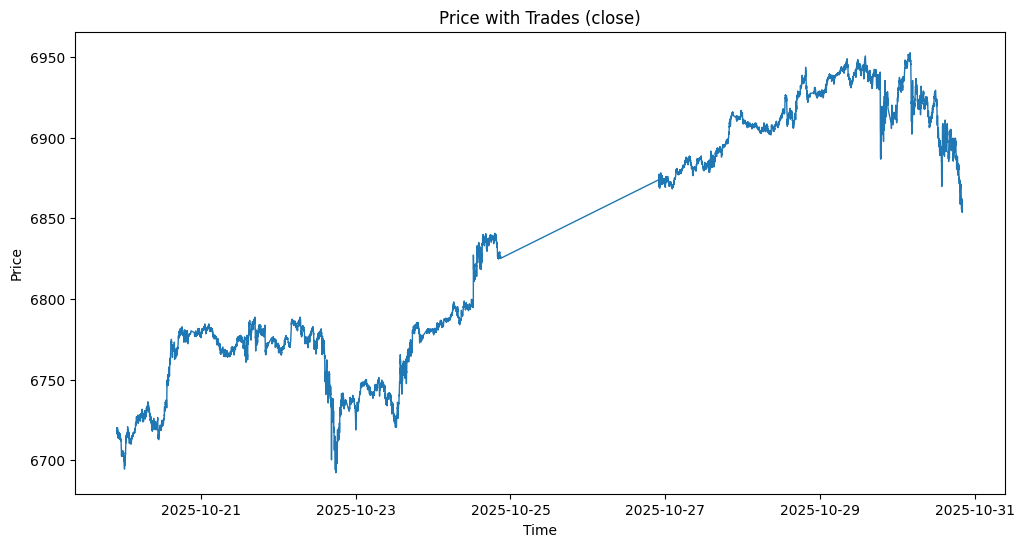

In [48]:

# Visual helper
def plot_price_with_trades(df_1m: pd.DataFrame, trades: pd.DataFrame, start=None, end=None):
    seg = df_1m.copy()
    if start: seg = seg[seg.index >= pd.Timestamp(start, tz="UTC")]
    if end:   seg = seg[seg.index <= pd.Timestamp(end, tz="UTC")]
    plt.figure(figsize=(12,6))
    plt.plot(seg.index, seg["close"].values, linewidth=1.0)
    for _, r in trades.iterrows():
        if r["entry_time"] >= seg.index.min() and r["entry_time"] <= seg.index.max():
            color = "g" if r["direction"]=="bullish" else "r"
            plt.scatter([r["entry_time"]], [r["entry_price"]], marker="^" if color=="g" else "v")
            if r["exit_time"] is not None:
                plt.scatter([r["exit_time"]], [r["exit_price"]], marker="x")
    plt.title("Price with Trades (close)")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()

if LOG_FVGS:
    import numpy as np
    def bucket_counts(df, name):
        if df.empty:
            print(f"[LOG] {name}: no fvgs")
            return
        bins = np.quantile(df["size"], [0, .25, .5, .75, 1.0])
        bins[0] = df["size"].min()
        bins[-1] = df["size"].max()
        cats = pd.cut(df["size"], bins=np.unique(bins), include_lowest=True)
        print(f"[LOG] {name} counts by size bucket:")
        display(df.groupby([cats,"direction"]).size().unstack(fill_value=0))
    bucket_counts(fvgs_to_frame(htf_fvgs), "HTF")
    bucket_counts(fvgs_to_frame(ltf_fvgs), "LTF")

# Example:
plot_price_with_trades(one_min, results, start="2025-10-10", end="2025-10-30 20:00")
